# 预测捐赠可能性

---
## 数据介绍

此数据为1994年美国人口普查收集的数据，目的是从其他的一些公开的可获得的资源中以准确地建模被调查者的收入是否超过50000美元。

这个项目的数据集来自[UCI机器学习知识库](https://archive.ics.uci.edu/ml/datasets/Census+Income)。

---
## 探索数据

In [1]:
# 导入库
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()

# 导入可视化代码visuals.py
import visuals as vs

# 内部显示
%matplotlib inline

# 导入人口普查数据
data = pd.read_csv("census.csv") 

# 显示第一条记录
display(data.head(n=1))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [2]:
# 总的记录数
n_records = data.shape[0]

# 被调查者的收入大于$50,000的人数
n_greater_50k = data[data['income']=='>50K'].shape[0]

# 被调查者的收入最多为$50,000的人数
n_at_most_50k = data[data['income']=='<=50K'].shape[0]

# 被调查者收入大于$50,000所占的比例
greater_percent = float(n_greater_50k)/float(n_records)*100
# 打印结果
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


---
## 预处理

In [3]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

#### 转换倾斜的连续特征

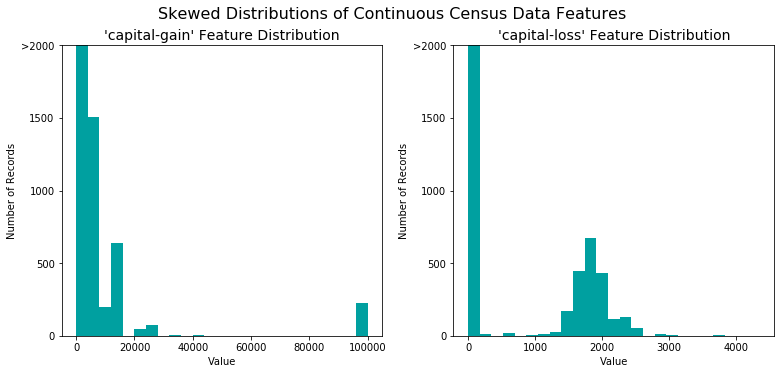

In [4]:
# 可视化 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw)

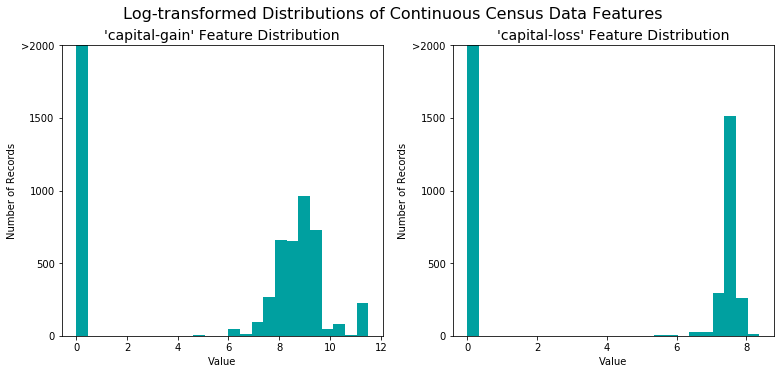

In [5]:
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化对数转换后 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw, transformed = True)

### 规一化数字特征

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))



,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### 独热编码

In [7]:
# TODO：使用pandas.get_dummies()对'features_raw'数据进行独热编码
features = pd.get_dummies(features_raw)

# TODO：将'income_raw'编码成数字值
z={'<=50K':0,'>50K':1}
income = income_raw.map(z)

# 打印经过独热编码之后的特征数量
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### 混洗和切分数据

In [8]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0,
                                                    stratify = income)
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
                                                    stratify = y_train)

# 显示切分的结果
print "Training set has {} samples.".format(X_train.shape[0])
print "Validation set has {} samples.".format(X_val.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 28941 samples.
Validation set has 7236 samples.
Testing set has 9045 samples.


---
## 评价模型性能

### 评价方法 F-beta score

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


 $\beta = 0.5$ 的时候更多的强调查准率，为**F$_{0.5}$ score** （F-score）。

### 天真的预测器的性能

*选择一个无论什么情况都预测被调查者年收入大于 \$50,000 的模型，计算其的准确率，查准率，查全率和 F-score*  


In [9]:

def cal(a):
    global accuracy,precision,recall,fscore
    
    
    TP=0.0
    FN=0.0
    FP=0.0
    TN=0.0
    
    for x in y_val:
        if x==a:
            TP+=1

    FP=y_val.count()-TP

    # 计算准确率
    accuracy = (TP+TN)/(TP+FN+FP+TN)

    # 计算查准率 Precision
    precision = TP/(TP+FP)

    # 计算查全率 Recall
    recall = TP/(TP+FN)

    # 设置beta=0.5，计算F-score
    beta=0.5
    fscore = (1+beta*beta)*(precision*recall)/((beta*beta*precision)+recall)
    
    if a==0:
        # 打印结果
        print "less than &50000 on validation data: \n \
        Accuracy score: {:.4f} \n \
        Precision: {:.4f} \n \
        Recall: {:.4f} \n \
        F-score: {:.4f}".format(accuracy, precision, recall, fscore)
    else:
        print "greater than $50000 Predictor on validation data: \n \
        Accuracy score: {:.4f} \n \
        Precision: {:.4f} \n \
        Recall: {:.4f} \n \
        F-score: {:.4f}".format(accuracy, precision, recall, fscore)
cal(0)
cal(1)


less than &50000 on validation data: 
         Accuracy score: 0.7522 
         Precision: 0.7522 
         Recall: 1.0000 
         F-score: 0.7914
greater than $50000 Predictor on validation data: 
         Accuracy score: 0.2478 
         Precision: 0.2478 
         Recall: 1.0000 
         F-score: 0.2917


### 监督学习模型
我在 scikit-learn使用这三个模型尝试：
集成方法，决策树，svm


In [10]:
# ：从sklearn中导入两个评价指标 - fbeta_score和accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_val: features validation set
       - y_val: income validation set
    '''
    
    results = {}
    
    # 使用sample_size大小的训练数据来拟合学习器
    start = time() # 获得程序开始时间
    
    learner.fit(X_train.iloc[0:sample_size],y_train.iloc[0:sample_size])

    end = time() # 获得程序结束时间
    
    # 计算训练时间
    results['train_time'] = end-start
    
    #  得到在验证集上的预测值
    #  然后得到对前300个训练数据的预测结果
    
    start = time() # 获得程序开始时间
    
    predictions_val =  learner.predict(X_val)
    predictions_train = learner.predict(X_train.iloc[0:300])
    
    end = time() # 获得程序结束时间
    
    # 计算预测用时
    results['pred_time'] = end-start
            
    # 计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train.iloc[0:300],predictions_train)
        
    # 计算在验证上的准确率
    results['acc_val'] = accuracy_score(y_val,predictions_val)
    
    # 计算在最前面300个训练数据上的F-score
    results['f_train'] = fbeta_score(y_train.iloc[0:300],predictions_train,beta=0.5)
        
    # 计算验证集上的F-score
    results['f_val'] = fbeta_score(y_val,predictions_val,beta=0.5)
       
    # 成功
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # 返回结果
    return results

### 初始模型的评估


RandomForestClassifier trained on 289 samples.
RandomForestClassifier trained on 2894 samples.
RandomForestClassifier trained on 28941 samples.
DecisionTreeClassifier trained on 289 samples.
DecisionTreeClassifier trained on 2894 samples.
DecisionTreeClassifier trained on 28941 samples.
SVC trained on 289 samples.


/Users/hl/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 2894 samples.
SVC trained on 28941 samples.


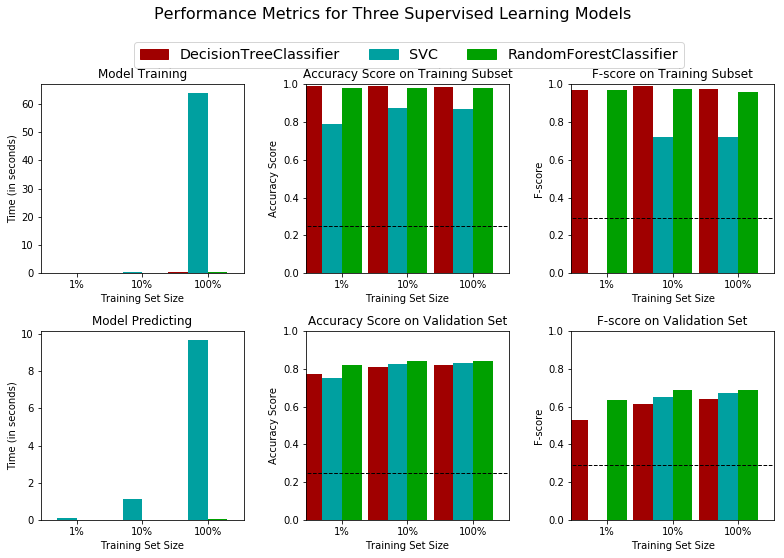

In [ ]:
# 从sklearn中导入三个监督学习模型
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import svm

# 初始化三个模型
clf_A = RandomForestClassifier(n_estimators=10,random_state=1)
clf_B = tree.DecisionTreeClassifier(random_state=1)
clf_C = svm.SVC(random_state=1)

# 计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(X_train.shape[0]*0.01)
samples_10 = int(X_train.shape[0]*0.1)
samples_100 = int(X_train.shape[0])

 
# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

# 可视化
vs.evaluate(results, accuracy, fscore)

----
## 提高效果
使用随机森林在整个训练集（`X_train`和`y_train`）上使用网格搜索优化以更好的 F-score。

In [ ]:
#导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# cross_validator = KFold(n_splits=10)

# 初始化分类器
clf = RandomForestClassifier(n_estimators=10,random_state=1,min_samples_leaf=1)


# 创建参数列表
parameters = {'n_estimators':[6,7,8,9,10,11,12,13,14,15],'min_samples_leaf':[1,2,3]}

# 创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score,beta=0.5)

# 在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(estimator=clf,param_grid=parameters,scoring=scorer,cv=10)

grid_obj =grid_obj.fit(X_train,y_train)

# 用训练数据拟合网格搜索对象并找到最佳参数
# 得到estimator
best_clf = grid_obj.best_estimator_

# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# 汇报调参前和调参后的分数
print "Unoptimized model\n------"
print "Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions))
print "Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5))

#### 结果:
 
| 评价指标         | 天真预测器           | 未优化的模型        | 优化的模型        |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| 准确率          |       0.25          |      0.84|    0.86         |
| F-score        |       0.29          |      0.69         |    0.74         |

### 提取特征重要性

In [ ]:
#导入一个有'feature_importances_'的监督学习模型
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot


# 在训练集模型
model = best_clf

# 提取特征重要性
importances = model.feature_importances_ 

init_notebook_mode(connected=True)
trace1=go.Histogram(x=X_train[y_train==0]['age'].values,name='0')
trace2=go.Histogram(x=X_train[y_train==1]['age'].values,name='1')
# print X_train

data=[trace1,trace2]
iplot(data)

# 绘图
vs.feature_plot(importances, X_train, y_train)

### 特征选择

In [ ]:
# 导入克隆模型的功能
from sklearn.base import clone

# 减小特征空间
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_val_reduced = X_val[X_val.columns.values[(np.argsort(importances)[::-1])[:5]]]

# 在前面的网格搜索的基础上训练一个“最好的”模型
clf_on_reduced = (clone(best_clf)).fit(X_train_reduced, y_train)

# 做一个新的预测
reduced_predictions = clf_on_reduced.predict(X_val_reduced)

# 对于每一个版本的数据汇报最终模型的分数
print "Final Model trained on full data\n------"
print "Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, best_predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, reduced_predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, reduced_predictions, beta = 0.5))

### 测试模型

In [ ]:
#TODO test your model on testing data and report accuracy and F score

clf_last = best_clf

# 做一个预测
last_predictions = clf_last.predict(X_test)


#我选择的此模型是我选择的算法当中表现最好的，另外通过对它进行调优获得了更好的效果，而训练时间也为多项式级别，综合考虑使用此模型

# 汇报最终模型的分数
print "Final Model trained on testdata------"
print "Accuracy on validation data: {:.4f}".format(accuracy_score(y_test, last_predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_test, last_predictions, beta = 0.5))